### Library Import

In [5]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


In [47]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [96]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl_all.pkl'), 'rb') as pickle_file:
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_even_ratio.pkl'), 'rb') as pickle_file:
    test_data = pickle.load(pickle_file)


In [ ]:
#resize test data
import random 
random.seed(42)
random.shuffle(test_data)
test_data_images, test_data_labels = zip(*test_data)
images_test, labels_test = zip(*test_data)

images_final_test = []
for img in images_test:
    img = Image.fromarray(img)
    img = img.resize((186, 100))
    images_final_test.append(np.array(img))

test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in images_final_test]
test_data_images = np.array(test_data_images)/255

Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [98]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)

U5 Images: 
---------------


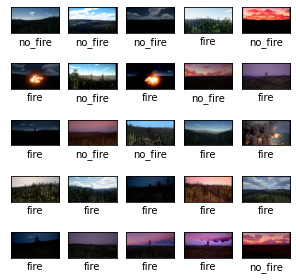

In [99]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = 5

    class_names = ['no_fire','fire']
    plt.figure(figsize=(5,5))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])

print('U5 Images: \n---------------')
plot_images(train_images, train_labels)

Test Real Images: 
---------------


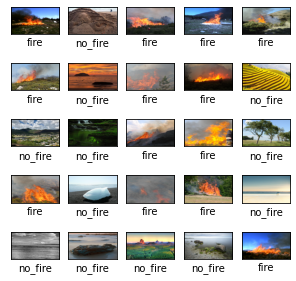

In [100]:
print('Test Real Images: \n---------------')
plot_images(test_data_images, test_data_labels)

In [103]:
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0,1307
1,1,1849


In [104]:
df = pd.DataFrame([label[0] for label in test_data_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['test_data_label', 'count_of_label']
df

,test_data_label,count_of_label
0,0,250
1,1,250


In [105]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]

In [106]:
input_shape

TensorShape([100, 186, 3])

In [108]:
len(train_images)

3156

# Image Agmentation and Sample Model 

In [109]:
# initial model with augment layer

augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697
model = Sequential([
  data_augmentation,
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

epochs = 25
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/25
98/98 [==============================] - 173s 2s/step - loss: 0.6308 - tp: 1601.0000 - fp: 958.0000 - tn: 369.0000 - fn: 294.0000 - accuracy: 0.6114 - precision: 0.6256 - recall: 0.8449 - auc: 0.6508 - prc: 0.7539 - val_loss: 0.5441 - val_tp: 142.0000 - val_fp: 43.0000 - val_tn: 118.0000 - val_fn: 92.0000 - val_accuracy: 0.6582 - val_precision: 0.7676 - val_recall: 0.6068 - val_auc: 0.7718 - val_prc: 0.8585
Epoch 2/25
98/98 [==============================] - 164s 2s/step - loss: 0.5419 - tp: 1258.0000 - fp: 375.0000 - tn: 977.0000 - fn: 612.0000 - accuracy: 0.6937 - precision: 0.7704 - recall: 0.6727 - auc: 0.7688 - prc: 0.8522 - val_loss: 0.6072 - val_tp: 210.0000 - val_fp: 117.0000 - val_tn: 44.0000 - val_fn: 24.0000 - val_accuracy: 0.6430 - val_precision: 0.6422 - val_recall: 0.8974 - val_auc: 0.7943 - val_prc: 0.8779
Epoch 3/25
98/98 [==============================] - 179s 2s/step - loss: 0.5236 - tp: 1333.0000 - fp: 357.0000 - tn: 968.0000 - fn: 564.0000 - accuracy: 0.7

In [144]:
predictions = [model.predict(tf.expand_dims(img, 0)) for img in test_data_images]
scores = [tf.nn.softmax(prediction) for prediction in predictions]
pred_labels = [np.argmax(score) for score in scores]

In [145]:
tf.math.confusion_matrix(test_data_labels, pred_labels, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[250,   0],
       [250,   0]], dtype=int32)>

In [152]:
#testing load model
model.save("artifacts/model_all.h5")
model = tf.keras.models.load_model('artifacts/model_all.h5')
width = model.input_shape[2]
height = model.input_shape[1]

print(width, height)

186 100


In [117]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

In [153]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,50])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [115]:
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

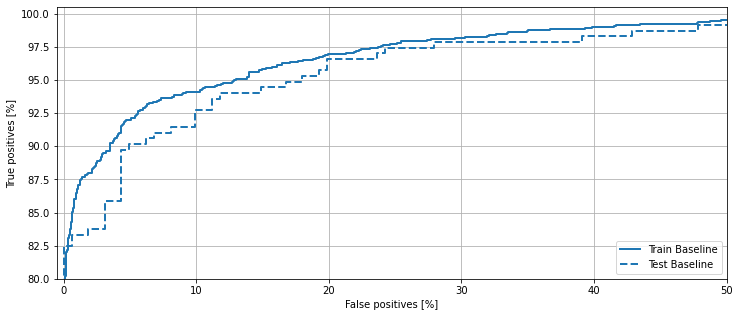

In [154]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [119]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

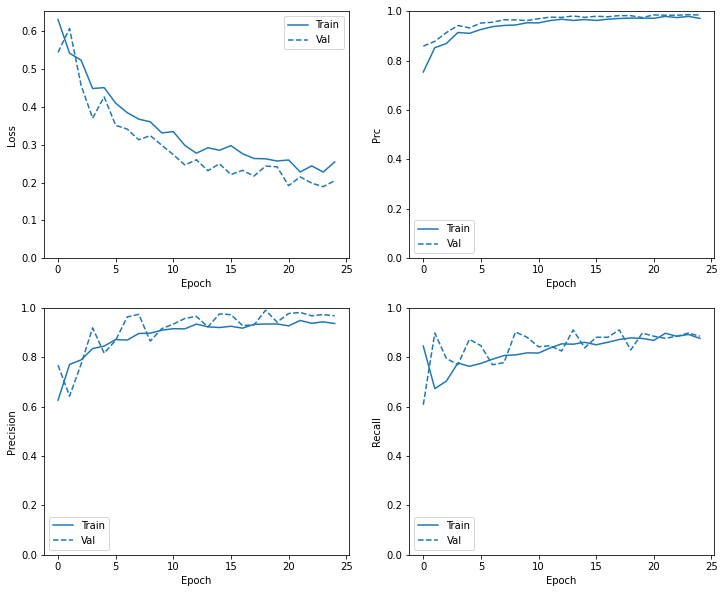

In [155]:
plot_metrics(history)

In [121]:
line_chart(history)

,epoch,variable,value
0,0,accuracy,0.611421
1,1,accuracy,0.693669
2,2,accuracy,0.714153
3,3,accuracy,0.779019
4,4,accuracy,0.777778


alt.Chart(...)

# Hyperparameter Tuning

In [14]:
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard
%reload_ext tensorboard
#! rm -rf ./logs/

In [15]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))#,'adam', 'Nadam'])) #'sgd','Adagrad'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []

test_data_images, test_data_labels = zip(*test_data)

# epochs = 50
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 88/91
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 88/93
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/91

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            units.append(num_units)
            dropouts.append(dropout_rate)
            optimizers.append(optimizer)
            run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                    HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER,
                    params, losses, accuracies, f1_scores, precisions, recalls, cms,
                    units, dropouts, optimizers, histories, augmentModel=True)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'}
Epoch 1/50
48/48 [==============================] - 27s 512ms/step - loss: 0.9068 - accuracy: 0.6022 - f1_m: 0.6567 - precision_m: 0.5579 - recall_m: 0.8576
Epoch 2/50
48/48 [==============================] - 23s 476ms/step - loss: 0.5696 - accuracy: 0.7328 - f1_m: 0.7193 - precision_m: 0.5725 - recall_m: 0.9789
Epoch 3/50
48/48 [==============================] - 25s 513ms/step - loss: 0.4642 - accuracy: 0.8028 - f1_m: 0.7210 - precision_m: 0.5699 - recall_m: 0.9950
Epoch 4/50
48/48 [==============================] - 25s 521ms/step - loss: 0.3714 - accuracy: 0.8358 - f1_m: 0.7213 - precision_m: 0.5695 - recall_m: 0.9963
Epoch 5/50
48/48 [==============================] - 24s 492ms/step - loss: 0.3389 - accuracy: 0.8582 - f1_m: 0.7204 - precision_m: 0.5683 - recall_m: 0.9991
Epoch 6/50
48/48 [==============================] - 35s 732ms/step - loss: 0.2980 - accuracy: 0.8806 - f1_m: 0.7194 - precision_m: 

In [3]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

NameError: name 'units' is not defined

In [4]:
line_chart(histories[0])

NameError: name 'line_chart' is not defined

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(len(list(modelDf.optimizers))):
    cls = modelDf.iloc[i,2]
    plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()